# Virtual screening

Notebook inspired by [Tutorial for the Teach-Discover-Treat (TDT) Competition 2014](https://github.com/sriniker/TDT-tutorial-2014/tree/master) by Sereina Riniker and Gregory Landrum.

Install dependencies if necessary (uncomment and run):

In [15]:
# !pip install -r requirements.txt

## 1. Primary screening data

We will focus on screening data for *Plasmodium falciparum*, parasite that causes malaria. This disease causes over 600 thousand deaths anually, mostly among African children. First effective malaria vaccine was approved by WHO in 2023, meeting their goal of >75% efficacy (reduction in risk of getting sick). Subsequently, it was approved and distributed in Ghana and Nigeria. However, research in this area is far from over.

Our dataset comes from high-throughput screening (HTS) campaigns from around 2010-2012. It was used for [TDT competition](http://www.tdtproject.org/challenge-1---malaria-hts.html). Note that this data contains imprecise labels, e.g. molecules can be false positives. For this dataset we also have a confirmatory (secondary) screen with precise labels, which we will use later.

In HTS, biological activity is measured as a real value, e.g. [EC50](https://en.wikipedia.org/wiki/EC50) or [IC50](https://en.wikipedia.org/wiki/IC50), and typically standardized to z-score. Due to inherent measurement inaccuracy, it is preferred to threshold it and perform binary classification, i.e. active/non-active. Sometimes an "ambiguous" class is also introduced, to denote highly uncertain molecules, but here we will ignore all such compounds for simplicity.

For details and papers, see:
- [TDT challenge: Malaria High-throughput Screen](http://www.tdtproject.org/challenge-1---malaria-hts.html)
- ["Chemical genetics of Plasmodium falciparum" W. A. Guiguemde et al.](https://www.nature.com/articles/nature09099)
- ["Global Phenotypic Screening for Antimalarials" W. A. Guiguemde et al.](https://www.sciencedirect.com/science/article/pii/S1074552112000178?via%3Dihub)

First, we will load the data. It is slightly simplified, compared to the original TDT data, and compressed in Parquet format (original CSV is really big). `label` means whether activity in HTS was high enough to mark a molecule as a hit.

Data size: 305568


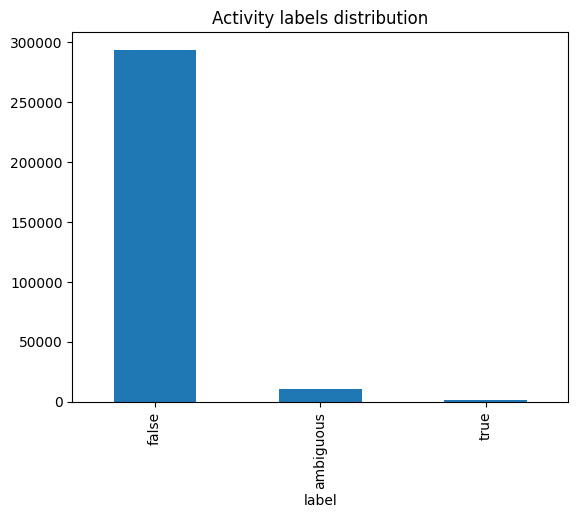

,SMILES,label
0,Cc1ccccc1c2nsc(SCC(=O)Nc3ccc(Br)cc3)n2,0
3,CN1\C(=N\C(=O)c2ccc(cc2)S(=O)(=O)N3CCCCC3)\Sc4...,0
4,COC(=O)c1ccc(NC(=O)CSc2nc(ns2)c3ccccc3C)cc1,0
7,CCOC(=O)c1c2CCCCc2sc1NC(=O)\C(=C/c3ccc(Cl)cc3)...,0
8,COc1ccccc1NC(=O)CSc2nc(ns2)c3ccccc3Cl,0
...,...,...
305563,CC(=O)Nc1cccc(NC(=O)CSc2nc(O)c3cnn(c4ccc(Cl)cc...,0
305564,CC(C)C(=O)NCc1c(nc2SCCn12)c3ccc(C)cc3,0
305565,COc1ccccc1n2ncc3c(O)nc(SCC(=O)Nc4cccc(Cl)c4)nc23,0
305566,Fc1ccc(cc1)c2nc3SCCn3c2CNC(=O)c4ccccc4Cl,0


In [1]:
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_parquet("data/malaria_hts_train.parquet")
print(f"Data size: {len(df)}")

df["label"].value_counts().plot.bar(title="Activity labels distribution")
plt.show()

df = df[df["label"] != "ambiguous"]
df["label"] = df["label"].map({"false": 0, "true": 1})

smiles_list = df["SMILES"].tolist()
labels = df["label"].values

display(df)

### Exercise 1

We need to prepare our data for further processing. We will use `preprocessing` module in *scikit-fingerprints* for this - [documentation](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/preprocessing.html).

Transform SMILES strings to RDKit `Mol` objects with `MolFromSmilesTransformer`. Use only RDKit-valid molecules with `valid_only` argument and `.transform_x_y` method.

`batch_size=1000` and `verbose=True` are recommended to see the progress bar.

Check how many molecules were removed during this process.

In [2]:
from skfp.preprocessing import MolFromSmilesTransformer

mol_from_smiles = MolFromSmilesTransformer(valid_only=True, n_jobs=-1, batch_size=1000, verbose=True)
mols, y = mol_from_smiles.transform_x_y(smiles_list, labels)

print(f"Number of valid molecules: {len(mols)}")
print(f"Number of invalid molecules: {len(smiles_list) - len(mols)}")

 65%|██████▌   | 193/295 [00:04<00:02, 48.22it/s][17:09:32] Explicit valence for atom # 19 S, 7, is greater than permitted
296it [00:05, 56.19it/s]                         


Number of valid molecules: 295134
Number of invalid molecules: 2


## 2. Filtering

First step in virtual screening (VS) workflows is filtering, removing molecules with unwanted features. *scikit-fingerprints* implements them in `filters` module. Both property-based and structural-based filters share the same interface with `.transform()` and .`transform_x_y()` methods, that return only molecules fulfilling the filter rules.

We can chain filters one after another, to apply many one after another. For example, to use all three PAINS filter sets, we can use it many times. Another useful downstream filter is ZINC druglike filter, used by ZINC database, which curates commercially available chemical compounds for virtual screening in medicinal chemistry.

However, scikit-learn pipelines don't support using `.transform_x_y()` currently, so we will need to apply them manually. Note that filters can be applied in any order - resulting molecules have to pass all of them. As such, if we focus on efficiency, putting the most restrictive filters first can be useful.

For ZINC filter definitions, see e.g. [scikit-fingerprints documentation](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/generated/skfp.filters.ZINCDruglikeFilter.html).

References:
- ["New Substructure Filters for Removal of Pan Assay Interference Compounds (PAINS) from Screening Libraries and for Their Exclusion in Bioassays" J. Baell, G. Holloway](https://doi.org/10.1021/jm901137j)
- ["ZINC − A Free Database of Commercially Available Compounds for Virtual Screening" J.Irwin, B. Shoichet](https://doi.org/10.1021/ci049714+)

In [3]:
from skfp.filters import PAINSFilter, ZINCDruglikeFilter


verbosity_args = dict(batch_size=1000, n_jobs=-1, verbose=True)

filt_pains_a = PAINSFilter(variant="A", **verbosity_args)
filt_pains_b = PAINSFilter(variant="B", **verbosity_args)
filt_pains_c = PAINSFilter(variant="C", **verbosity_args)
filt_zinc = ZINCDruglikeFilter(**verbosity_args)

print(f"Molecules before filtering: {len(mols)}")

mols_filtered, y_filtered = filt_pains_a.transform_x_y(mols, y)
print(f"Molecules after PAINS A: {len(mols_filtered)}")

mols_filtered, y_filtered = filt_pains_b.transform_x_y(mols_filtered, y_filtered)
print(f"Molecules after PAINS B: {len(mols_filtered)}")

mols_filtered, y_filtered = filt_pains_c.transform_x_y(mols_filtered, y_filtered)
print(f"Molecules after PAINS C: {len(mols_filtered)}")

mols_filtered, y_filtered = filt_zinc.transform_x_y(mols_filtered, y_filtered)
print(f"Molecules after ZINC druglike: {len(mols_filtered)}")

y_active = y_filtered.sum()
y_inactive = len(y_filtered) - y_active
print(f"Final inactive molecules: {y_inactive}")
print(f"Final active molecules: {y_active}")

<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterMatcherBase> already registered; second conversion method ignored.


Molecules before filtering: 295134


  0%|          | 0/295 [00:00<?, ?it/s]<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterMatcherBase> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterMatcherBase> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterMatcherBase> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterMatcherBase> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterMatcherBase> already registered; second conversion method ignored.
 15%|█▍        | 44/295 [00:00<00:04, 51.60it/s]<frozen importlib._bootstrap>:488: RuntimeWarnin

Molecules after PAINS A: 280754


281it [00:07, 35.92it/s]                         


Molecules after PAINS B: 275926


276it [00:31,  8.64it/s]                         


Molecules after PAINS C: 274527


275it [01:23,  3.31it/s]                         

Molecules after ZINC druglike: 247646
Final inactive molecules: 246585
Final active molecules: 1061


### Exercise 2

A common criticism of molecular filters is that they are too conservative, and limit the explored chemical space too much. The most famous Lipinski's Rule of 5 filter is often shown as an example of this. It was originally designed to keep orally bioavailable drugs.

Try out the Lipinski's Rule of 5 filter, and two alternatives proposed in literature:
- Beyond Rule of 5
- Rule of Veber

You will find them in [scikit-fingerprints documentation](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/filters.html).

Filter the initial set of ~295 thousand compounds. Use filters separately (not as a pipeline) and compare how many non-actives and actives did they leave. Was there any big difference in speed?

**Note:** do not overwrite the variables `mols_filtered` and `y_filtered` from above, otherwise you will need to recompute them.

In [4]:
from skfp.filters import BeyondRo5Filter, LipinskiFilter, RuleOfVeberFilter

for filter_class, filter_name in zip([BeyondRo5Filter, LipinskiFilter, RuleOfVeberFilter],
                                ["Beyond Ro5", "Lipinski", "Veber"]):
    filter = filter_class(**verbosity_args)
    mols_filtered2, y_filtered2 = filter.transform_x_y(mols, y)
    y_active = y_filtered2.sum()
    y_inactive = len(y_filtered2) - y_active
    print(f"Final molecules after {filter_name}: {len(mols_filtered2)}")
    print(f"Final inactive molecules: {y_inactive}")
    print(f"Final active molecules: {y_active}")

296it [00:09, 31.38it/s]                         


Final molecules after Beyond Ro5: 295035
Final inactive molecules: 293509
Final active molecules: 1526


296it [00:06, 46.50it/s]                         


Final molecules after Lipinski: 293410
Final inactive molecules: 291910
Final active molecules: 1500


296it [00:03, 86.64it/s]                         

Final molecules after Veber: 291876
Final inactive molecules: 290378
Final active molecules: 1498


### What next?

At this point, we typically would get a chemist involved to look over rejected active molecules. Some that look interesting to experts could be rescued, to be fixed in later parts, e.g. their toxicity reduced through structural changes. However, here we focus on a fully automated virtual screening workflow.

Then, we can do two things:
1. Confirm actives in confirmatory screen
2. Perform virtual screening (VS)

We will do the latter, since we focus on the virtual screening workflow. If you are interested, see the bonus exercise for confirmatory screen exercise.

## Ligand-based virtual screening

Ligand-based VS uses 2D molecular structures, and is a much cheaper and scalable alternative to the 3D structure-based VS. We use molecular fingerprints to quantify similarity to active molecules, and those most similar are assumed to also be active. This can be seen as either a binary classification (active/non-active), or similarity searching, i.e. finding molecules most similar to the active ones.

Here, we will focus on classification approach, which has a few advantages:
- typically great results
- quite noise-resistant
- fast and scalable

Note that the classification is often highly imbalanced, so we definitely need to use class weighting or other techniques.

Steps:
1. Train-test split
2. Make a pipeline (fingerprint + classifier), tune it and train on training set.
3. Calculate a score (e.g. probability) for each test molecule.
4. Rank test compounds by their score (sort descending), and evaluate this ranking with chosen metric(s).
5. Repeat steps 1-4 many times (bootstrap), e.g. 50.

We want the method to recognize structural and functional properties of actives, putting true actives from test set first. In practice, if the test set was a large library of commercially available compounds, we would take first e.g. 100 and test them in the lab. Therefore, we need early enrichment - highly probably actives as close to the beginning as possible. Metrics like enrichment factor (EF) take this into consideration. Due to high imbalance and variance, bootstrap helps with evaluation.

**Additional notes**

The workflow above assumes no hyperparameter tuning for fingerprints. This is quite common, but of course we could perform such tuning. It 
would require slight changes, mainly creating a validation set (perhaps with bootstrap or cross-validation), and calculating final fingerprints after tuning.

The similarity search approach would work as follows. After train-test set, for each test molecule we compute similarity to actives from the train set, and take the highest similarity. This is called MAX fusion. This is the score, and we sort compounds in the order of descending similarity.

Further reading:
- ["Open-source platform to benchmark fingerprints for ligand-based virtual screening" S. Riniker, G. Landrum](https://doi.org/10.1186/1758-2946-5-26)
- ["Heterogeneous Classifier Fusion for Ligand-Based Virtual Screening: Or, How Decision Making by Committee Can Be a Good Thing" S. Riniker et al.](https://doi.org/10.1021/ci400466r)

If we don't tune fingerprint hyperparameters, we can do this once before the entire training. Even if we do tune them, due to bootstrapping precomputing the actual matrices and caching them at this point can be useful. For simplicity, we will just use default settings of AtomPair fingerprint, using scikit-fingerprints and `AtomPairFingerprint` class.

In [5]:
from skfp.fingerprints import AtomPairFingerprint


fp_ap = AtomPairFingerprint(batch_size=1000, n_jobs=-1, verbose=True)
X_ap = fp_ap.transform(mols_filtered)

248it [00:03, 63.11it/s]                         


Now we need 2 functions:
1. Classifier training, which also gets scores (probabilities) for test compounds
2. Scores ranking and evaluation.

Popular classifiers are logistic regression and tree-based ensembles like Random Forest or boosting. We will use LightGBM, since it's very fast.

## Exercise 3

Implement `get_vs_scores` function.

1. Train LightGBM classifier ([documentation](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)) with settings:
   - `class_weight="balanced"`
   - `n_jobs=-1`
   - `random_state=0`
   - `verbose=-1` - to turn off unnecessary logging
3. Predict probability of positive class (active) for test compounds. Those are the molecule scores.
4. Calculate metrics using scikit-learn and scikit-fingerprints ([documentation](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/metrics.html)): AUROC and enrichment factor at 5% (EF5%).
5. Return calculated metrics.

In [8]:
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from skfp.metrics import enrichment_factor


def perform_vs_experiment(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
) -> tuple[float, float]:
    lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=0, verbose=-1)
    lgbm_clf.fit(X_train, y_train)

    y_pred = lgbm_clf.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred)
    ef = enrichment_factor(y_test, y_pred, fraction=0.05)

    return roc_auc, ef

In [9]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_ap, y_filtered, test_size=0.2, random_state=0, stratify=y_filtered
)

auroc, ef = perform_vs_experiment(X_train, X_test, y_train, y_test)
print(f"AUROC: {auroc:.2%}")
print(f"Enrichment factor at 5% (EF5%): {ef:.2f}")

AUROC: 81.75%
Enrichment factor at 5% (EF5%): 10.66


Since we have so few actives, single train-test split is not enough. We should perform bootstrapping, i.e. repeat the experiment many times with different splits, and average the results.

In [10]:
from tqdm import tqdm


def perform_boostrap_vs_experiment(
    X_fp: np.ndarray, y: np.ndarray, n_repetitions: int = 10
) -> None:
    auroc_values = []
    ef_values = []
    for i in tqdm(range(n_repetitions), total=n_repetitions):
        X_train, X_test, y_train, y_test = train_test_split(
            X_fp, y, test_size=0.2, random_state=i, stratify=y_filtered
        )
        auroc, ef = perform_vs_experiment(X_train, X_test, y_train, y_test)
        auroc_values.append(auroc)
        ef_values.append(ef)

    auroc_mean = np.mean(auroc_values)
    auroc_std = np.std(auroc_values)
    ef_mean = np.mean(ef_values)
    ef_std = np.std(ef_values)
    
    print(f"AUROC: {auroc_mean:.2%} +- {auroc_std:.2%}")
    print(f"Enrichment factor at 5% (EF5%): {ef_mean:.2f} +- {ef_std:.2f}")


In [11]:
perform_boostrap_vs_experiment(X_ap, y_filtered)

100%|██████████| 10/10 [00:38<00:00,  3.88s/it]

AUROC: 84.27% +- 2.50%
Enrichment factor at 5% (EF5%): 11.78 +- 0.97


AUROC can be easily interpreted. However, is this enrichment factor good or not? It has minimal value 0, random classifier would get value 1, but the maximum value has a slightly more complicated formula.

Mark fraction as $X$, number of actives $n$, and test set size $N$. Then, the maximal value is $1/X$ if $X \geq n/N$, and $N/n$ otherwise.

In [13]:
fraction = 0.05
n = sum(y_test)
N = len(y_test)

max_ef = 1 / fraction if fraction >= n/N else N/n

print(f"Maximal EF5% value: {max_ef:.2f}")

Maximal EF5% value: 20.00


## Exercise 4

Perform the virtual screening experiment with other fingerprints:
- ECFP4
- RDKit fingerprint
- MACCS
- Laggner

Use scikit-fingerprints [documentation](https://scikit-fingerprints.github.io/scikit-fingerprints/modules/fingerprints.html) as needed. Which fingeprint got the best result?

If you have the time, you can also try out the count variants.

In [14]:
from skfp.fingerprints import ECFPFingerprint, RDKitFingerprint, MACCSFingerprint, LaggnerFingerprint


for fp_cls, fp_name in [
    (ECFPFingerprint, "ECFP"),
    (RDKitFingerprint, "RDKit"),
    (MACCSFingerprint, "MACCS"),
    (LaggnerFingerprint, "Laggner"),
]:
    fp = fp_cls(batch_size=1000, n_jobs=-1, verbose=True)
    X_fp = fp.transform(mols_filtered)
    print(f"{fp_name} fingerprint")
    perform_boostrap_vs_experiment(X_fp, y_filtered)
    print()


248it [00:04, 54.51it/s]                         


ECFP fingerprint


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


AUROC: 87.60% +- 1.95%
Enrichment factor at 5% (EF5%): 13.88 +- 0.68



248it [00:25,  9.63it/s]                         


RDKit fingerprint


100%|██████████| 10/10 [01:28<00:00,  8.83s/it]


AUROC: 80.49% +- 2.03%
Enrichment factor at 5% (EF5%): 11.92 +- 0.42



248it [01:29,  2.77it/s]                         


MACCS fingerprint


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


AUROC: 86.17% +- 3.12%
Enrichment factor at 5% (EF5%): 12.66 +- 0.84



248it [02:50,  1.46it/s]                         


Laggner fingerprint


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]

AUROC: 87.04% +- 2.08%
Enrichment factor at 5% (EF5%): 13.28 +- 0.63



Now, that we have the final model selected, real-world deployment steps would be:
1. Retrain model on all available data
2. Download a large-scale virtual screening collection, e.g. [Enamine Screening Collection](https://enamine.net/compound-collections/screening-collection) of ~4.4 million compounds
3. Filter and predict probabilities, selecting most likely molecules
4. Select diverse compounds
5. Perform confirmatory screening

## Bonus exercise

We got about 1000 compounds after filtering. Testing them thoroughly in the lab may be too expensive, so we want to pick a subset for purely economic reasons, e.g. 500.

Some of those may turn active, but toxic, expensive to synthesize, or be rejected for other reasons. Therefore, we want diverse molecules, to have many alternatives. This is the problem of **maximum diversity picking (MDP)**. It is typically approximated with heuristics, such as clustering.

Molecules typically use ECFP vectorization. We first pick diverse cluster centers (centroid molecules), e.g. with Butina (sphere exclusion) clustering - a density-based clustering frequently used for molecules. Alternatively, MaxMin algorithm can be used, which tries to maximize the sum of Tanimoto distances between molecules. Each molecule is then assigned to its nearest cluster based on Tanimoto similarity to the cluster centroid. We can pick molecules from each cluster until we have as many molecules as we can test.

1. Implement Butina (sphere exclusion) clustering and cluster the active molecules after filtering. [This tutorial](https://greglandrum.github.io/rdkit-blog/posts/2020-11-18-sphere-exclusion-clustering.html) will be useful.
2. Plot molecules from cluster centers - are they diverse? Do their general structure (scaffolds) look different?
3. Pick 1 molecule from each cluster randomly in a loop, to get 500 molecules.
4. Calculate pairwise Tanimoto similarity between resulting molecule set to quantitatively assess their diversity. Plot the distribution. Are they generally below 0.65, commonly used as similarity threshold?

The resulting list would be submitted for synthesis in a confirmatory screen. [TDT data](http://www.tdtproject.org/challenge-1---malaria-hts.html) provides EC50 values for molecules that were tested by them in confirmatory screen, and you can also compare our molecules (based on SMILES) with those. See [this tutorial](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb) for details.